<div class="alert alert-warning">
이 노트북을 처음 열어보면 아마도 그림이나 표의 수식 등이 제대로 표시되지 않고 있을 것입니다. 이때는 오른쪽 상단의 "Not Trusted"버튼을 눌러서 나오는 안내창의 "Trust"를 선택해주세요. 노트북에 저장되어 있던 결과들이 제대로 표시될 것입니다. Jupyter Notebook이 아닌 Jupyter Lab 환경이라면 상단 "View" 메뉴의 "Activate Command Palette" 항목을 선택한 다음 "Trust Notebook"이라는 기능을 검색하여 실행하면 됩니다. 검색을 할 때에는 앞 글자 "tr"만 입력하여도 해당 항목이 나옵니다.
</div>

# 3. 생물계절

지금까지 2회에 걸쳐 작물의 성장을 생체량 증가라는 측면에서 살펴보았는데요. 이번 시간에는 시선을 바꾸어 작물모형의 중추라고 볼 수도 있는 생물계절(phenology)에 대해 살펴보겠습니다. 생물계절은 생물이 성장하면서 거치는 여러 발달과정의 시점(timing)이 결정되는 과정(process)에 대해 연구하는 분야입니다. 작물에서는 영양생장에서 생식생장으로 넘어가는 시점이라든지, 꽃이 피는 개화시점 등을 결정하는 것에 관여한다고 볼 수 있습니다. 주로 주변의 환경요인에 많은 영향을 받는데, 그 중에서도 특히 온도에 민감하게 반응하기 때문에 여기서는 열 시간(thermal time) 개념을 위주로 생물계절 모형을 만들어보도록 하겠습니다.

In [1]:
using Cropbox

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

In [3]:
using CSV
using DataFrames
using Dates
using TimeZones

## 3.1. Growing Degree Days

Growing Degree Days(GDD)는 가장 간단한 형태의 열온도 모형입니다. 특정 온도($T$)에 대해 작물이 반응하여 생장하는 정도(growing degree)는 기본적으로 해당 온도와 기준 온도($T_{base}$) 간의 차이를 의미하며, 최적 온도($T_{opt}$) 이상에서는 더 이상 증가하지 않습니다. 또한 음수가 되지 않도록 0에서 더 이상 내려가지 않습니다. 이러한 온도차이를 일 단위 기준으로 계산한다면(growing degree **days**) 그 단위를 $K d^{-1}$로 정의할 수 있습니다. 이를 장기간에 걸쳐 적산한 값(cumulative growing degree days)을 적산온도 혹은 생장도일이라고 부르며, 주로 특정 발달과정에 도달하는 기준으로 사용됩니다. 적산하기 전의 단위 값과 적산한 후의 값을 모두 GDD라고 혼용하여 부르기도 하는데 여기서는 헷갈리지 않도록 이들을 구분하여 모형을 만들어 보겠습니다.

$$
\begin{align}
\mathrm{GD}(T) &= \max \{ 0, \min \{ T, T_{opt} \} - T_{base} \} \\
\mathrm{GDD}(T) &= \frac{\mathrm{GD}(T)}{1\ d} \\
\mathrm{cGDD} &= \sum_i^n \mathrm{GDD}(T_i) \\
\end{align}
$$

In [4]:
@system GrowingDegreeDay begin
    t(context.clock.time): time      ~ track(u"d")
    Δt(context.clock.step): timestep ~ preserve(u"d")

    T:  temperature                  ~ preserve(parameter, u"°C")
    Tb: base_temperature             ~ preserve(parameter, u"°C")
    To: optimal_temperature          ~ preserve(parameter, u"°C")

    GD(T, Tb, To): growing_degree                => min(T, To) - Tb ~ track(min = 0, u"K")
    GDD(GD, Δt):   growing_degree_day            => GD / Δt         ~ track(u"K/d")
    cGDD(GDD):     cumulative_growing_degree_day                    ~ accumulate(u"K")
end

GrowingDegreeDay

시스템을 구동하기 위해서는 `Controller` 믹스인(mix-in)이 필요하니 `GDDController`를 따로 만들어주겠습니다.

In [5]:
@system GDDController(GrowingDegreeDay, Controller)

GDDController

그 다음, 일 단위 시간으로 $T_{base}$ = 8.0 °C, $T_{opt}$ = 32.0 °C의 조건에서 GDD가 계산되는 조건을 가정해보겠습니다.

In [6]:
gdd_config = @config (
    :Clock => (;
        step = 1u"d",
    ),
    :GrowingDegreeDay => (;
        Tb = 8.0,
        To = 32.0,
    ),
)

Config for 2 systems:
  Clock
    step = 1 d
  GrowingDegreeDay
    Tb = 8.0
    To = 32.0

그럼 온도($T$)마다 계산되는 GDD를 확인해보겠습니다. 일 평균기온이 해당 온도로 유지될 때 하루에 적산될 수 있는 열온도의 양이라고 볼 수 있습니다.

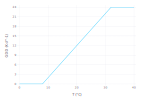

In [7]:
visualize(GDDController, :T, :GDD;
    config = gdd_config,
    xstep = :0 => :T => 0:40,
    kind = :line,
)

다른 기준온도($T_{base}$)와 최적온도($T_{opt}$)를 사용하면 어떻게 달라지는지 확인해보겠습니다.

In [8]:
manipulate(GDDController, :T, :GDD;
    config = :Clock => :step => 1u"d",
    parameters = :GrowingDegreeDay => (;
        Tb = 0:0.1:10,
        To = 1:40,
    ),
    xstep = :0 => :T => -5:45,
    ylim = (0, 40),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["GrowingDegreeDay"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Tb"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe006479900, Task (runnable) @0x00007fe006479900), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };

이러한 일 단위 GDD를 일정 기간 적산하여 모두 더한 값이 적산 GDD(`cGDD`)가 됩니다. 일정 온도가 30일 동안 유지되었을 때 그 추이를 계산해보겠습니다.

In [9]:
manipulate(GDDController, :t, :cGDD;
    config = :Clock => :step => 1u"d",
    parameters = :GrowingDegreeDay => (;
        T  = -5:45,
        Tb = 0:0.1:10,
        To = 1:40,
    ),
    stop = 30u"d",
    ylim = (0, 1000),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["GrowingDegreeDay"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["T"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 45, :min => -5, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 1 listeners. Value:
20, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe00427f1f0, Task (runnable) @0x00007fe00427f1f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    }

이제 이 GDD 모형을 실제 적용하는 사례를 살펴보겠습니다. 작물의 생장에서 엽 출현(leaf appearance)이나 생식생장기(reproductive stage) 전환 등은 특정 기준온도의 적산을 통해 설명이 가능한 경우가 많습니다. 즉, 누적 GDD를 계산하여 특정 값을 넘어갈 때 새로운 엽이 출현하거나 영양생장에서 생식생장으로 넘어가는 처리를 해주는 것입니다.

여기서는 옥수수의 엽 출현을 GDD로 모의하기 위해 자료를 불러오겠습니다. 미국 메릴랜드주의 USDA-ARS 연구소에서 2002년에 실험을 진행하며 측정한 기상자료입니다.

In [10]:
corn_weather = CSV.read("./03-Phenology/corn_weather.csv", DataFrame) |> unitfy

,year,jday,rad,Tavg,Tmax,Tmin,rainfall,date
,Int64,Int64,Quantit…,Quantit…,Quantit…,Quantit…,Quantit…,Date
1,2002,135,295.8 W m^-2,14.9 °C,22.1 °C,8.6 °C,0 mm,2002-05-15
2,2002,136,297.9 W m^-2,18.0 °C,27.7 °C,4.9 °C,0 mm,2002-05-16
3,2002,137,224.2 W m^-2,21.3 °C,27.3 °C,14.3 °C,3 mm,2002-05-17
4,2002,138,95.8 W m^-2,12.5 °C,17.7 °C,8.0 °C,11 mm,2002-05-18
5,2002,139,314.9 W m^-2,9.6 °C,15.6 °C,4.0 °C,0 mm,2002-05-19
6,2002,140,284.6 W m^-2,10.1 °C,15.6 °C,4.3 °C,0 mm,2002-05-20
7,2002,141,275.0 W m^-2,8.8 °C,14.5 °C,2.6 °C,0 mm,2002-05-21
8,2002,142,320.0 W m^-2,11.6 °C,20.1 °C,1.4 °C,0 mm,2002-05-22
9,2002,143,318.5 W m^-2,14.7 °C,24.0 °C,3.0 °C,0 mm,2002-05-23


일 단위로 여러가지 기상자료가 있는데 이중에서 기온만 살펴보겠습니다.

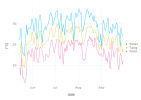

In [11]:
visualize(corn_weather, :date, [:Tmax, :Tavg, :Tmin]; kind = :line)

위에서 만든 `GrowingDegreeDay` 시스템에서는 온도(`T`)가 모수(parameter)로 정의되어 있었지만 이 값은 처음에 한번 설정(configuration)되고 나면 다른 값으로 바뀌지 않고 계속 유지(preserve)되는 구조입니다. 매일 변화하는 기온값을 넣어주려면 우선 해당 시계열 자료를 불러오는 부분, 그리고 현재 모형이 모의하고 있는 시간에 맞추어 기온값을 추출해내는 부분이 필요합니다. Cropbox에서는 전자를 `provide`, 후자를 `drive`라는 종류의 변수로 처리할 수 있습니다.

In [12]:
@system Temperature begin
    calendar(context)             ~      ::Calendar
    date(calendar.date)           ~ track::date

    data                          ~ provide(parameter, index = :date, init = date)
    T:                temperature ~ drive(from = data, by = :Tavg, u"°C")
end

Temperature

`Temperature` 시스템은 외부 자료에서 기온을 불러오기 위한 믹스인(mix-in)으로 `provide`와 `drive`를 활용합니다. 사용하는 시계열 자료의 시간축이 `YYYY/MM/DD`(연/월/일) 형식의 날짜(calendar date)로 되어 있다고 가정하고 이를 처리하기 위해 Cropbox에서 제공하는 `Calendar` 시스템을 함께 사용하고 있습니다.

- `provide`는 데이터 프레임(data frame)의 특정 열(column)을 색인(`index`)으로 지정하여 현재 모의중인 모형의 상태에 맞추어 값을 제공(provide)하는 역할을 합니다. 기본은 `context.clock.time`에 연동되어 값이 추출되며, 다른 변수를 사용하려면 `init` 태그에 넣어주면 됩니다. 외부 자료를 설정(configuration)을 통해 넣어줄 수 있도록 `parameter` 태그도 함께 붙여줍니다.

- `drive`는 이렇게 준비된 자료 원본(data source)에서 실제 값을 추출해주는 역할을 합니다. `provide`로 만든 변수의 이름(`from`)과 추출하려는 열의 이름(`by`)을 함께 넣어주면 되고, 필요하다면 해당 값의 단위(`u".."`)를 붙여줄 수 있습니다.

- `Calendar` 시스템은 모든 시스템에 기본적으로 포함되는 `Clock`과 유사하게 현재 시간(`time`)에 관련된 정보를 제공하는데, 그 단위가 시간(`u"hr"`)이 아니라 `ZonedDateTime`(Cropbox에서는 `datetime`으로 지정 가능)으로 되어 있어 날짜를 구분할 수 있다는 점이 특징입니다. 보다 일반적인 `DateTime`이 아니라 `ZonedDateTime`을 사용하는 것은 지역마다 다른 시간대(time zone)을 원활하게 처리하기 위함입니다. 참고로 `Calendar` 시스템은 아래와 같이 정의되어 있습니다. `simulate()` 함수의 `stop` 조건으로 사용할 수 있는 `stop`과 `count` 변수를 제공하는 것을 확인할 수 있습니다.

```julia
@system Calendar begin
    init            ~ preserve::datetime(extern, parameter)
    last => nothing ~ preserve::datetime(extern, parameter, optional)

    time(t0 = init, t = context.clock.time) => t0 + convert(Cropbox.Dates.Second, t) ~ track::datetime
    date(time)                              => Cropbox.Dates.Date(time)              ~ track::date

    stop(time, last) => begin
        isnothing(last) ? false : (time >= last)
    end ~ flag

    step(context.clock.step) ~ preserve(u"hr")
    count(init, last, step) => begin
        isnothing(last) ? nothing : (last - init) / step
    end ~ preserve::int(round, optional)
end
```

그럼 `Temperature` 시스템과 내부에 포함된 `Calendar` 시스템에 대한 설정을 만들어보겠습니다.

In [13]:
corn_config = @config (
    :Calendar => (;
        init = ZonedDateTime(2002, 5, 15, tz"America/New_York"),
        last = ZonedDateTime(2002, 9, 30, tz"America/New_York"),
    ),
    :Clock => (;
        step = 1u"d",
    ),
    :Temperature => (;
        data = corn_weather,
    ),
)

Config for 3 systems:
  Calendar
    init = ZonedDateTime(2002, 5, 15, tz"America/New_York")
    last = ZonedDateTime(2002, 9, 30, tz"America/New_York")
  Clock
    step = 1 d
  Temperature
    data = 139×10 DataFrame…

`Calendar` 시스템의 모의 시작일(`init`)과 종료일(`last`) 모수를 설정하기 위해 `ZonedDateTime` 형식을 사용하고 있습니다. 실험이 진행된 메릴랜드주는 미국 동부에 위치하며 해당 시간대의 이름은 `tz"America/New_York"`입니다. 참고로 원활한 실습을 위해 시간은 일 단위로 설정하겠습니다.

`provide` 형식의 `data` 변수에 들어갈 데이터 프레임(`corn_weather`)은 설정 내부에 그대로 넣어주면 됩니다.

이제 모의를 위한 시스템을 조립해보겠습니다. 앞에서 만든 `GrowingDegreeDay`를 바탕으로 온도 변수(`T`)를 `Temperature` 믹스인에서 제공하는 외부 기온 자료로 대체한 `GDDCalculator`가 만들어졌습니다.

In [14]:
@system GDDCalculator(GrowingDegreeDay, Temperature, Controller)

GDDCalculator

설정 역시 마찬가지로 앞에서 만들었던 GDD 관련 설정(`gdd_config`)과 외부자료 관련 설정(`corn_config`)을 조합하여 새로 만들어줍니다.

In [15]:
gddc_config = @config (
    corn_config,
    gdd_config,
)

Config for 4 systems:
  Calendar
    init = ZonedDateTime(2002, 5, 15, tz"America/New_York")
    last = ZonedDateTime(2002, 9, 30, tz"America/New_York")
  Clock
    step = 1 d
  Temperature
    data = 139×10 DataFrame…
  GrowingDegreeDay
    Tb = 8.0
    To = 32.0

모의는 동일한 방식으로 진행합니다. 단, 종료 조건(`stop`)에는 `Calendar`에서 시작일(`init`)과 종료일(`last`) 기준으로 자동 계산되는 `calendar.stop` 혹은 `calendar.count` 변수를 넣어주면 됩니다.

In [16]:
simulate(GDDCalculator;
    config = gddc_config,
    stop = "calendar.count",
    index = :date,
    target = [:GDD, :cGDD],
)

,date,GDD,cGDD
,Date,Quantit…,Quantit…
1,2002-05-15,6.9 K d^-1,0.0 K
2,2002-05-16,10.0 K d^-1,6.9 K
3,2002-05-17,13.3 K d^-1,16.9 K
4,2002-05-18,4.5 K d^-1,30.2 K
5,2002-05-19,1.6 K d^-1,34.7 K
6,2002-05-20,2.1 K d^-1,36.3 K
7,2002-05-21,0.8 K d^-1,38.4 K
8,2002-05-22,3.6 K d^-1,39.2 K
9,2002-05-23,6.7 K d^-1,42.8 K


우선 GDD 계산에 사용되는 기온(`T`) 값을 출력해보겠습니다.

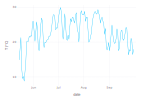

In [17]:
visualize(GDDCalculator, :date, :T;
    config = gddc_config,
    stop = "calendar.stop",
    kind = :line,
)

이를 바탕으로 매일 계산되는 단위 GDD값을 출력해보겠습니다.

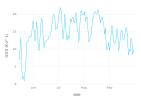

In [18]:
visualize(GDDCalculator, :date, :GDD;
    config = gddc_config,
    stop = "calendar.stop",
    kind = :line,
)

이 값들을 매일 적산하면 누적 GDD를 구할 수 있습니다.

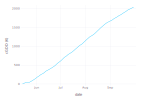

In [19]:
visualize(GDDCalculator, :date, :cGDD;
    config = gddc_config,
    stop = "calendar.stop",
    kind = :line,
)

그럼 이제 이 누적 GDD를 기반으로 옥수수 엽 출현율을 계산해보겠습니다. 한장의 잎이 출현할 때까지 필요한 누적 GDD를 출엽기간(phyllochron)이라고 부르고, 이 출엽기간만큼 GDD가 누적될 때마다 새로운 잎이 더해지는 구조입니다. 이렇게 출현하는 엽수를 계산하기 위해 앞에서 만든 `GrowingDegreeDay`와 `Temperature` 시스템을 기반으로 엽수에 대한 변수를 추가하여 새로운 시스템 `LeafAppearanceGD`를 만들어보겠습니다.

In [20]:
@system LeafAppearanceGD(GrowingDegreeDay, Temperature, Controller) begin
    N: leaves_total ~ preserve::int(parameter)
    p: phyllochron  ~ preserve(parameter, u"K")
    
    n(cGDD, p): leaves_appeared => begin
        cGDD / p
    end ~ track::int(round = :floor)

    match(n, N)                        => (n >= N) ~ flag
    stop(m = match, s = calendar.stop) => (m || s) ~ flag
end

LeafAppearanceGD

기본적으로 출엽수(`n`)는 누적 GDD(`cGDD`)를 출엽기간(`p`)로 나누어 버림(floor)한 값과 같습니다. 이를 위해 출엽기간(`p`)이 모수로 추가되었습니다. 그리고 총출엽수(`N`) 역시 모수로 추가하여 해당 조건에서는 모의를 종료할 수 있도록 하였습니다.

여기서 새로 등장하는 `flag` 변수는 `track`과 유사하지만 참(`true`)과 거짓(`false`) 두가지 값만을 가지는 `Bool` 타입에 특화되어 있습니다. 어떤 변수의 값이 특정 조건을 만족하는지 아닌지 판단하는데 주로 사용합니다. 특히, 일반 `track` 변수와는 달리 `&`(AND)나 `|`(OR) 같은 논리연산자(logical operator)로 값을 조합하여 새로운 조건을 만들어내는 것이 쉽기 때문에 `track`이나 `accumulate`와 같은 변수의 `when` 조건에 활용이 되고는 합니다. 해당 조건을 만족할 때만 계산이 수행되어 값이 변하도록 조정할 수 있는 것이죠.

여기서 만든 두가지 `flag` 변수는 아래와 같습니다.

- `match`는 현재 출엽수(`n`)가 모수로 주어진 총출엽수(`N`)와 같거나 큰지 판단하는 변수입니다.
- `stop`은 모의를 종료해도 되는지 판단하는 변수입니다. 보통은 위의 `match`가 성사된 경우(`true`)가 되겠지만, 간혹 넣어준 기온 자료의 끝까지 적산을 하였는데도 기준점을 넘지 못하는 경우, `Calendar`에 입력된 종료일(`last`)을 기준으로 강제 종료시키는 상황도 고려하고 있습니다.

그럼 출엽기간(`p`)은 43 K, 총출엽수(`N`)는 20장으로 설정을 만들겠습니다. 이때 모형의 다른 모수들은 기존과 동일하게 가져가기 위하여 앞에서 만들었던 설정을 기반으로 새로운 설정을 추가합니다. 참고로, 출엽기간(phyllochron)이 43 K라는 것은 일 평균기온이 21.5 °C라고 가정하였을 때 이틀이면 새로운 잎이 한장씩 나온다는 의미가 되겠습니다.

In [21]:
lagd_config = @config (
    corn_config,
    gdd_config,
    :LeafAppearanceGD => (;
        N = 20,
        p = 43,
    ),
)

Config for 5 systems:
  Calendar
    init = ZonedDateTime(2002, 5, 15, tz"America/New_York")
    last = ZonedDateTime(2002, 9, 30, tz"America/New_York")
  Clock
    step = 1 d
  Temperature
    data = 139×10 DataFrame…
  GrowingDegreeDay
    Tb = 8.0
    To = 32.0
  LeafAppearanceGD
    N = 20
    p = 43

모의를 수행하면서 관련 변수들을 여럿 출력해보겠습니다.

In [22]:
lagd_result = simulate(LeafAppearanceGD;
    config = lagd_config,
    stop = :stop,
    index = :date,
    target = [:T, :GDD, :cGDD, :p, :n, :match, :stop],
)

,date,T,GDD,cGDD,p,n,match,stop
,Date,Quantit…,Quantit…,Quantit…,Quantit…,Int64,Bool,Bool
1,2002-05-15,14.9 °C,6.9 K d^-1,0.0 K,43.0 K,0,0,0
2,2002-05-16,18.0 °C,10.0 K d^-1,6.9 K,43.0 K,0,0,0
3,2002-05-17,21.3 °C,13.3 K d^-1,16.9 K,43.0 K,0,0,0
4,2002-05-18,12.5 °C,4.5 K d^-1,30.2 K,43.0 K,0,0,0
5,2002-05-19,9.6 °C,1.6 K d^-1,34.7 K,43.0 K,0,0,0
6,2002-05-20,10.1 °C,2.1 K d^-1,36.3 K,43.0 K,0,0,0
7,2002-05-21,8.8 °C,0.8 K d^-1,38.4 K,43.0 K,0,0,0
8,2002-05-22,11.6 °C,3.6 K d^-1,39.2 K,43.0 K,0,0,0
9,2002-05-23,14.7 °C,6.7 K d^-1,42.8 K,43.0 K,0,0,0


결과의 마지막 10열만 따로 추려서 보면 누적 GDD(`cGDD`)가 873.1 K가 되었을 때 출엽수(`n`)가 20장이 되어 `match`가 충족되고 이에 맞춰 종료 조건인 `stop`까지 활성화되어 모의가 종료된 것을 확인할 수 있습니다.

In [23]:
last(lagd_result, 10)

,date,T,GDD,cGDD,p,n,match,stop
,Date,Quantit…,Quantit…,Quantit…,Quantit…,Int64,Bool,Bool
1,2002-07-08,23.5 °C,15.5 K d^-1,733.5 K,43.0 K,17,0,0
2,2002-07-09,28.1 °C,20.1 K d^-1,749.0 K,43.0 K,17,0,0
3,2002-07-10,24.9 °C,16.9 K d^-1,769.1 K,43.0 K,17,0,0
4,2002-07-11,20.9 °C,12.9 K d^-1,786.0 K,43.0 K,18,0,0
5,2002-07-12,20.5 °C,12.5 K d^-1,798.9 K,43.0 K,18,0,0
6,2002-07-13,22.0 °C,14.0 K d^-1,811.4 K,43.0 K,18,0,0
7,2002-07-14,20.8 °C,12.8 K d^-1,825.4 K,43.0 K,19,0,0
8,2002-07-15,24.2 °C,16.2 K d^-1,838.2 K,43.0 K,19,0,0
9,2002-07-16,26.7 °C,18.7 K d^-1,854.4 K,43.0 K,19,0,0


출엽수를 그래프로 그려보면 아래와 같습니다. 기온이 낮은 경우에는 상대적으로 출현에 시간이 더 걸리는 것을 확인할 수 있습니다. 즉, 실제 생장이 진행된 날짜(calendar date) 그 자체가 아니라 온도에 관련하는 열 시간(thermal time)에 의존하는 엽 출현율을 표현하고 있는 것입니다.

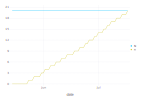

In [24]:
visualize(LeafAppearanceGD, :date, [:N, :n];
    config = lagd_config,
    stop = :stop,
    kind = :line,
)

그럼 실제 실험에서 측정된 옥수수 출엽수와는 얼마나 차이가 나는지 비교해보도록 하겠습니다. 마찬가지로 미국 메릴랜드주의 USDA-ARS 연구소에서 2002년에 수집한 자료입니다.

In [25]:
corn_obs = CSV.read("./03-Phenology/corn_sample.csv", DataFrame) |> unitfy
dropmissing!(corn_obs, :TotLfNo)

,year,jday,date,SampleNo,Stage,VSLfNo,Ht,Diameter,TotLfNo
,Int64,Int64,Date,Int64,String3?,Int64?,Float64?,Quantit…?,Int64
1,2002,162,2002-06-11,1,V5,5,48.0,missing,7
2,2002,162,2002-06-11,2,V5,5,44.0,missing,8
3,2002,162,2002-06-11,3,V5,5,40.0,missing,7
4,2002,162,2002-06-11,4,V5,5,49.5,missing,8
5,2002,162,2002-06-11,5,V5,5,51.5,missing,9
6,2002,162,2002-06-11,6,V5,5,48.5,missing,8
7,2002,162,2002-06-11,7,V5,5,49.0,missing,8
8,2002,162,2002-06-11,8,V5,5,40.5,missing,7
9,2002,162,2002-06-11,9,V4,4,39.0,missing,7


여기서 대략 1주일 단위로 측정된 총엽수(`TotLfNo`)를 모형의 모의 결과와 함께 출력해보겠습니다.

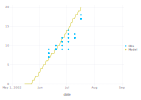

In [26]:
p = visualize(corn_obs, :date, :TotLfNo;
    xlim = (Date(2002, 5), Date(2002, 9)),
    ylim = (0, 20),
    name = "Obs",
)
visualize!(p, LeafAppearanceGD, :date, :n;
    config = lagd_config,
    stop = :stop,
    kind = :line,
    name = "Model",
)

정량적평가를 위해 RMSE(root mean square error; 평균 제곱근 오차)와 EF([Nash-Sutcliffe model efficiency](https://en.wikipedia.org/wiki/Nash–Sutcliffe_model_efficiency_coefficient))도 계산해보겠습니다.

In [27]:
evaluate(LeafAppearanceGD, corn_obs;
    config = lagd_config,
    index = :date,
    target = :TotLfNo => :n,
    stop = :stop,
    metric = :rmse,
)

2.6331223544175333

In [28]:
evaluate(LeafAppearanceGD, corn_obs;
    config = lagd_config,
    index = :date,
    target = :TotLfNo => :n,
    stop = :stop,
    metric = :ef,
)

0.24500907441016329

## 3.2. Beta 함수

GDD는 간단한 수식으로 생물계절에 관련된 여러가지 기작들을 설명할 수 있지만 한가지 단점이 있습니다. 바로 고온에서의 식물 생장을 제대로 반영하지 못한다는 점인데요. 온도가 높아질수록 발달이 가속되거나 유지되는 것이 아니라 실제로는 느려지거나 멈출 수 있다는 점을 반영하지 못하고 있습니다.

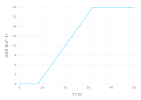

In [29]:
visualize(GDDController, :T, :GDD;
    config = gdd_config,
    xstep = :0 => :T => 0:50,
    kind = :line,
)

보다 현실적인 형태의 열 시간(thermal time) 개념을 도입하는 방법에는 여러가지가 있는데요. 여기서는 보다 자유로운 형태의 곡선을 표현할 수 있는 Beta 함수를 활용해보도록 하겠습니다.


$$
\begin{align}
r(T) &= r_{max} \left( \frac{T_{ceil} - T}{T_{ceil} - T_{opt}} \right) \left( \frac{T - T_{min}}{T_{opt} - T_{min}} \right) ^ {\frac{T_{opt} - T_{min}}{T_{ceil} - T_{opt}}} \\
R &= \sum_i^n \mathrm{r}(T_i) \\
\end{align}
$$

이 수식은 특정 기작에서의 온도에 의존하는 발달률($r$; development rate, $\mathrm{d}^{-1}$)을 표현하고 있습니다. 앞에서의 단위 GDD($\mathrm{K}\ \mathrm{d}^{-1}$)에 대응하는 부분입니다.

특징으로는 일단 온도 관련 모수가 많이 추가된 것을 보실 수 있는데요. 최저온도($T_{min}$; minimum temperature), 최적온도($T_{opt}$; optimal temperature), 천정온도($T_{ceil}$; ceiling temperature)가 있습니다. GDD의 최적온도가 여기서는 최적온도와 천정온도 두가지로 세분화되었다고 보실 수도 있겠습니다.

그리고 앞에서는 누적 GDD를 계산한 다음 출엽기간(phyllochron)과 같은 기준값과 비교하는 과정이 있었지만, 여기서는 정규화(normalization)하여 상대적인 값으로 계산하는 것도 특징입니다. 예를 들어, 엽출현율이라면 누적된 $R$이 1이 되었을 때 새로운 엽출현이 발생하도록 맞춰지도록 구성합니다. 이를 위해 최적 온도에서의 최대 발달률($r_{max}$)이 모수로 추가되어 있는데요. 만약 최적 온도에서 2일이 지날 때마다 엽출현이 발생한다면 $r_{max}$는 0.5 $\mathrm{d}^{-1}$가 되는 식입니다.

In [30]:
@system BetaFunc begin
    T:  temperature              ~ preserve(parameter, u"°C")
    Tn: minimum_temperature => 0 ~ preserve(parameter, u"°C")
    To: optimal_temperature      ~ preserve(parameter, u"°C")
    Tc: ceiling_temperature      ~ preserve(parameter, u"°C")
    rx: maximum_rate        => 1 ~ preserve(parameter, u"d^-1")

    r(T, Tn, To, Tc, rx): rate => begin
        rx * (Tc - T) / (Tc - To) * ((T - Tn) / (To - Tn))^((To - Tn) / (Tc - To))
    end ~ track(min = 0, max = rx, u"d^-1")

    D(r): cumulative_development ~ accumulate
end

BetaFunc

모수가 많고 식이 조금 더 복잡하지만 시스템 구현 자체는 크게 다르지 않습니다. `GDD` 대신에 `r`, `cGDD` 대신에 `D`가 되었다고 보시면 됩니다.

In [31]:
@system BFController(BetaFunc, Controller)

BFController

옥수수의 엽출현율에 대한 모수는 [Yan and Hunt (1999)](https://doi.org/10.1006/anbo.1999.0955)에서 참고하였습니다.

In [32]:
bf_config = @config (
    :BetaFunc => (;
        rx = 0.433,
        To = 31.7,
        Tc = 41.1,
    ),
)

Config for 1 system:
  BetaFunc
    rx = 0.433
    To = 31.7
    Tc = 41.1

그럼 온도에 따른 엽출현율(`r`) 변화를 확인해보겠습니다. 최적온도인 31.7 °C 부근에서 가장 높은 값이 나오고, 천정온도인 41.1 °C 이후에는 0으로 수렴하는 것을 볼 수 있습니다. GDD와 차이를 볼 수 있는 부분입니다.

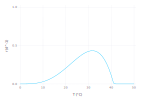

In [33]:
visualize(BFController, :T, :r;
    config = bf_config,
    xstep = :0 => :T => 0:50,
    kind = :line,
)

In [34]:
manipulate(BFController, :T, :r;
    parameters = :BetaFunc => (;
        rx = 0:0.1:1,
        To = 0:0.1:40,
        Tc = 0:0.1:60,
    ),
    xstep = :0 => :T => 0:50,
    ylim = (0, 1),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["BetaFunc"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["rx"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 11, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
6, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe006da0160, Task (runnable) @0x00007fe006da0160), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var 

이제 GDD 예제와 동일한 방식으로 실습을 진행하겠습니다. 먼저 외부 기온 자료를 불러올 수 있도록 시스템을 구성합니다.

In [35]:
@system BFCalculator(BetaFunc, Temperature, Controller)

BFCalculator

In [36]:
bfc_config = @config (
    corn_config,
    bf_config,
)

Config for 4 systems:
  Calendar
    init = ZonedDateTime(2002, 5, 15, tz"America/New_York")
    last = ZonedDateTime(2002, 9, 30, tz"America/New_York")
  Clock
    step = 1 d
  Temperature
    data = 139×10 DataFrame…
  BetaFunc
    rx = 0.433
    To = 31.7
    Tc = 41.1

In [37]:
simulate(BFCalculator;
    config = bfc_config,
    stop = "calendar.stop",
    index = :date,
    target = [:r, :D],
)

,date,r,D
,Date,Quantit…,Float64
1,2002-05-15,0.0946154 d^-1,0.0
2,2002-05-16,0.157796 d^-1,0.0946154
3,2002-05-17,0.238611 d^-1,0.252411
4,2002-05-18,0.0571212 d^-1,0.491022
5,2002-05-19,0.025831 d^-1,0.548144
6,2002-05-20,0.0301684 d^-1,0.573974
7,2002-05-21,0.0197514 d^-1,0.604143
8,2002-05-22,0.0457946 d^-1,0.623894
9,2002-05-23,0.0910904 d^-1,0.669689


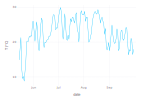

In [38]:
visualize(BFCalculator, :date, :T;
    config = bfc_config,
    stop = "calendar.stop",
    kind = :line,
)

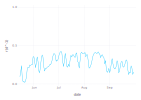

In [39]:
visualize(BFCalculator, :date, :r;
    config = bfc_config,
    stop = "calendar.stop",
    kind = :line,
)

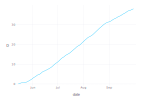

In [40]:
visualize(BFCalculator, :date, :D;
    config = bfc_config,
    stop = "calendar.stop",
    kind = :line,
)

마지막으로 옥수수 엽출현을 모의하는 시스템을 만들어보겠습니다. 적산온도를 먼저 계산하고 이를 특전 기준값과 비교하여 엽출현을 판단하는 GDD와는 달리 Beta 함수 기반에서는 발달률(development rate; `r`)이 모수 값에 따라 상대적으로 조정되어 이미 우리가 원하는 엽출현율(leaf appearance rate)을 의미하고 있습니다. 이에 따라 코드는 오히려 더 간단해졌습니다.

In [41]:
@system LeafAppearanceBF(BetaFunc, Temperature, Controller) begin
    N: leaves_total       ~ preserve::int(parameter)
    
    n(D): leaves_appeared ~ track::int(round = :floor)
    
    match(n, N)                        => (n >= N) ~ flag
    stop(m = match, s = calendar.stop) => (m || s) ~ flag
end

LeafAppearanceBF

마찬가지로 최종엽수가 20장이 되는 것으로 가정합니다.

In [42]:
labf_config = @config (
    corn_config,
    bf_config,
    :LeafAppearanceBF => (;
        N = 20,
    ),
)

Config for 5 systems:
  Calendar
    init = ZonedDateTime(2002, 5, 15, tz"America/New_York")
    last = ZonedDateTime(2002, 9, 30, tz"America/New_York")
  Clock
    step = 1 d
  Temperature
    data = 139×10 DataFrame…
  BetaFunc
    rx = 0.433
    To = 31.7
    Tc = 41.1
  LeafAppearanceBF
    N = 20

In [43]:
labf_result = simulate(LeafAppearanceBF;
    config = labf_config,
    stop = :stop,
    index = :date,
    target = [:T, :r, :D, :n, :match, :stop],
)

,date,T,r,D,n,match,stop
,Date,Quantit…,Quantit…,Float64,Int64,Bool,Bool
1,2002-05-15,14.9 °C,0.0946154 d^-1,0.0,0,0,0
2,2002-05-16,18.0 °C,0.157796 d^-1,0.0946154,0,0,0
3,2002-05-17,21.3 °C,0.238611 d^-1,0.252411,0,0,0
4,2002-05-18,12.5 °C,0.0571212 d^-1,0.491022,0,0,0
5,2002-05-19,9.6 °C,0.025831 d^-1,0.548144,0,0,0
6,2002-05-20,10.1 °C,0.0301684 d^-1,0.573974,0,0,0
7,2002-05-21,8.8 °C,0.0197514 d^-1,0.604143,0,0,0
8,2002-05-22,11.6 °C,0.0457946 d^-1,0.623894,0,0,0
9,2002-05-23,14.7 °C,0.0910904 d^-1,0.669689,0,0,0


In [44]:
last(labf_result, 10)

,date,T,r,D,n,match,stop
,Date,Quantit…,Quantit…,Float64,Int64,Bool,Bool
1,2002-07-20,26.0 °C,0.356472 d^-1,17.3176,17,0,0
2,2002-07-21,25.5 °C,0.344933 d^-1,17.674,17,0,0
3,2002-07-22,27.7 °C,0.391665 d^-1,18.019,18,0,0
4,2002-07-23,28.4 °C,0.403799 d^-1,18.4106,18,0,0
5,2002-07-24,23.4 °C,0.292895 d^-1,18.8144,18,0,0
6,2002-07-25,22.9 °C,0.280012 d^-1,19.1073,19,0,0
7,2002-07-26,20.0 °C,0.205625 d^-1,19.3873,19,0,0
8,2002-07-27,23.5 °C,0.295459 d^-1,19.593,19,0,0
9,2002-07-28,28.1 °C,0.398797 d^-1,19.8884,19,0,0


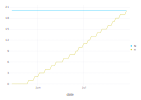

In [45]:
visualize(LeafAppearanceBF, :date, [:N, :n];
    config = labf_config,
    stop = :stop,
    kind = :line,
)

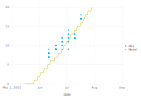

In [46]:
p = visualize(corn_obs, :date, :TotLfNo;
    xlim = (Date(2002, 5), Date(2002, 9)),
    ylim = (0, 20),
    name = "Obs",
)
visualize!(p, LeafAppearanceBF, :date, :n;
    config = labf_config,
    stop = :stop,
    kind = :line,
    name = "Model",
)

RMSE와 EF를 계산해보면 GDD 보다 조금 더 좋은 성능이 나오는 것을 확인할 수 있습니다. 물론 여기서는 서로 다른 논문의 모수들을 가져와서 비교한 것이라는 점은 감안해야 하겠습니다.

In [47]:
evaluate(LeafAppearanceBF, corn_obs;
    config = labf_config,
    index = :date,
    target = :TotLfNo => :n,
    stop = :stop,
    metric = :rmse,
)

2.0330600909302543

In [48]:
evaluate(LeafAppearanceBF, corn_obs;
    config = labf_config,
    index = :date,
    target = :TotLfNo => :n,
    stop = :stop,
    metric = :ef,
)

0.5499092558983666

## 3.3. Chilling-Forcing 모형

### 3.3.1. 개요

생물계절 현상의 종류에 따라서는 내부적으로 열 시간(thermal time) 적산의 개념이 여러 단계에 걸쳐 적용되어야 하는 경우도 있습니다. 예를 들어 벚꽃이 개화하기 위해서는 겨울에 일정 수준의 저온을 경험하여 휴면타파(dormancy break)가 이루어진 다음, 봄이 되어 상승한 기온에 맞춰 적산이 수행되어 개화의 시점이 결정됩니다. 즉, 전반부에는 특정 기준온도 이하의 저온이 음의 방향으로 적산되어 휴면타파일이 결정되고, 후반부에는 일반적인 GDD 모형처럼 기준온도 이상의 고온이 양의 방향으로 적산되어 개화일이 결정되는 것입니다. 2단계로 구성되어 복잡할 것 같지만 기술적으로는 GDD 모형을 두번 중첩한 것과 같은 형태라고 보시면 되겠습니다.

보다 구체적으로는 기존의 [휴면타파 모형](https://doi.org/10.1016/j.agrformet.2004.03.002)을 기반으로 하여 [개화기까지 확장한 모형](https://doi.org/10.1371/journal.pone.0027439)입니다.

$$
\begin{aligned}
T_a & = \begin{cases}
  T & \text{if } T \geq 0 \\
  0 & \text{otherwise}
\end{cases} \\
\Delta T & = \frac{T_a - T_c}{\Delta t} \\
c & = \begin{cases}
  \Delta T & \text{if } \Delta T < 0 \\
  0 & \text{otherwise}
\end{cases} \\
f & = \begin{cases}
  \Delta T & \text{if } \Delta T > 0 \\
  0 & \text{otherwise}
\end{cases} \\
\sum_{t_0}^{\hat{t}_d-1} c & > R_{\mathtt{C}} \geq \sum_{t_0}^{\hat{t}_d} c \\
\sum_{\hat{t}_d}^{\hat{t}-1} f & < R_{\mathtt{F}} \leq \sum_{\hat{t}_d}^{\hat{t}} f \\
\end{aligned}
$$

수식으로 표현하면 복잡해보이지만 결국 GDD 모형과 거의 동일합니다. 우선 임계온도(critical temperature; $T_c$)가 모수로 들어가는데, 현재 온도($T_a$)를 기준으로 chilling 혹은 forcing의 크기를 결정하게 됩니다. 이때 0 °C 이상의 상온만 고려하게 됩니다. 전반부 저온 누적(chilling) 단계에서는 부호가 음수이기 때문에 음의 방향으로 누적이 되어 저온요구도(chilling requirement; $R_{\mathtt{C}}$)를 만족할 때까지 진행이 되며, 이후에는 반대로 양의 방향으로 *고온*요구도(forcing requirement; $R_{\mathtt{F}}$)를 만족할 때까지 적산을 수행합니다. 이때 요구도가 만족된 시점의 일자($\hat{t}_d$)가 개화일로 결정되는 구조입니다.

In [49]:
@system ChillForceEstimator(Temperature, Controller) begin
    Tc: temperature_threshold ~ preserve(parameter, u"°C")
    Rc: chilling_requirement  ~ preserve(parameter, u"K")
    Rf: forcing_requirement   ~ preserve(parameter, u"K")

    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    Ta(T)                                    ~ track(min = 0, u"°C")
    Δt(context.clock.step)                   ~ preserve(u"d")
    ΔT(Ta, Tc, Δt)         => (Ta - Tc) / Δt ~ track(u"K/d")

    c(ΔT): chilling             ~ track(max = 0, u"K/d")
    C(c):  chilling_accumulated ~ accumulate(when = !d, u"K")

    d(C, Rc):    chilling_done => (C <= Rc) ~ flag

    f(ΔT): forcing              ~ track(min = 0, u"K/d")
    F(f):  forcing_accumulated  ~ accumulate(when = d, u"K")

    match(F, Rf)                       => (F >= Rf) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

ChillForceEstimator

전반부의 단위 시간당 저온강도(chilling)는 (소문자) `c`(`chilling`) 변수로 계산이 되며, 이를 누적한 것이 (대문자) `C`(`chilling_accumulated`) 변수가 되겠습니다. 이때 저온이 누적되는 조건(`when`)으로 `d`(`chilling_done`)가 활성화되지 않았을 때(`when = !d`)가 들어가는데요. 해당 flag 변수는 누적저온(`C`)이 저온요구도(`Rc`)를 통과할 때, 즉 음수이기 때문에 더 작아지는 경우에 활성화(`true`)됩니다.

반대로 후반부에서는 단위 시간당 *고온*강도(forcing)인 (소문자) `f`(`forcing`)가 누적되어 (대문자) `F`(`forcing_accumulated`)를 증가시켜 *고온*요구도(`Rf`)보다 커지는 순간을 기다리게 됩니다. 이때 누적이 되는 조건이 전반부와는 반대로 `d`(`chilling_done`)가 활성화되었을 때(`when = d`)로 정의되는 것을 볼 수 있습니다.

`f`가 `Rf`를 넘어서는 시점에 `match` 변수가 활성화되고 이에 따라 `stop`도 함께 활성화되어 모의를 끝내라는 신호로 작용합니다. 만약 조건이 맞지 않아 `match` 변수가 활성화될 수 없는 경우에는 `calendar.stop`에 따라 종료일을 기준으로 모의를 마무리하게 됩니다. 이러한 경우에는 개화일을 정할 수 없기 때문에 모의 결과를 별도로 입력해주어야 하는데요. 이를 위해서 아래와 같은 콜백(callback)을 `simulate()` 함수에 함께 넣어주고 있습니다.

In [50]:
callback(s, m) = if s.stop' && !s.match'
    m.result[end, :doy] = 365u"d"
end

callback (generic function with 1 method)

그리고 `simulate()` 함수를 수행하면 전체 모의 기간에 대한 기록이 결과로 저장이 되는데요. 개화일 예측 모형 입장에서는 해당 결과의 마지막 줄에서 개화가 되었는지(`match`), 되었다면 그 날짜(`doy`)가 언제인지만 확인하면 됩니다. 그러한 편의를 위해 별도로 `estimate()`라는 이름의 함수를 만들어서 사용하도록 하겠습니다. 그리고 각 연도에 해당하는 설정(configuration)을 만들어주는 `cherry_config()`라는 함수 역시 사용하는데 이에 대해서는 잠시 후 살펴보겠습니다.

In [51]:
estimate(S, years;
    config,
    index = [:year, :doy],
    target = [],
    stop = :stop,
    kwargs...
) = simulate(S;
    configs = @config(config + cherry_config.(years)),
    index,
    target,
    stop,
    snap = stop,
    callback,
    kwargs...
)

estimate (generic function with 1 method)

### 3.3.2. 기상자료

이번 실습에서 사용할 [벚꽃 개화 자료](https://www.nps.gov/subjects/cherryblossom/bloom-watch.htm)는 미국 워싱턴 DC의 국립공원에서 장기간 측정된 기록입니다. 이에 맞춰 사용할 기상자료는 근처의 공항에서 측정된 것입니다.

In [52]:
dc_weather = CSV.read("./03-Phenology/dc_weather.csv", DataFrame) |> unitfy

,date,Tavg,Tmin,Tmax
,Date,Quantit…,Quantit…,Quantit…
1,1936-09-01,25.2 °C,15.7 °C,29.6 °C
2,1936-09-02,22.2 °C,19.1 °C,25.2 °C
3,1936-09-03,22.2 °C,19.1 °C,25.2 °C
4,1936-09-04,22.5 °C,16.3 °C,28.0 °C
5,1936-09-05,21.8 °C,13.5 °C,26.8 °C
6,1936-09-06,21.5 °C,15.2 °C,25.7 °C
7,1936-09-07,23.8 °C,16.9 °C,30.2 °C
8,1936-09-08,27.3 °C,20.7 °C,32.9 °C
9,1936-09-09,28.7 °C,22.4 °C,33.5 °C


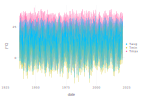

In [53]:
visualize(dc_weather, :date, [:Tavg, :Tmin, :Tmax]; kind = :line)

### 3.3.3. 설정

#### 3.3.3.1. 기온

자료가 확인 되었으니, 앞에서 만든 `ChillForceEstimator`의 `Temperature` 믹스인의 기상자료(`data`)에 들어갈 수 있도록 설정을 만들어주겠습니다.

In [54]:
dc_config = @config (
    :ChillForceEstimator => (;
        data = dc_weather,
    ),
)

Config for 1 system:
  ChillForceEstimator
    data = 31046×4 DataFrame…

#### 3.3.3.2. 시간

벚꽃 개화의 모의는 이전 연도 가을에 시작하여 당해 연도 봄에 종료하게 됩니다. 이렇게 모의를 수행하기 위해서는 각 연도별로 시작일(`init`)과 종료일(`last`)을 지정하는 설정(configuration)을 만들어주어야 하는데요. 매번 직접 만들기 번거롭기 때문에 아래와 같이 `cherry_config()`라는 함수를 만들어서 연도(`year`)만 넣어주면 해당 설정이 만들어질 수 있도록 해보겠습니다. 더불어 `Clock`의 간격(`step`) 기준은 일 단위로 하겠습니다.

In [55]:
cherry_config(year) = @config (
    :Calendar => (;
        init = ZonedDateTime(year-1, 10,  1, tz"UTC"),
        last = ZonedDateTime(year,    5, 31, tz"UTC"),
    ),
    :Clock => (;
        step = 1u"d",
    ),
)

cherry_config (generic function with 1 method)

In [56]:
cherry_config(2017)

Config for 2 systems:
  Calendar
    init = ZonedDateTime(2016, 10, 1, tz"UTC")
    last = ZonedDateTime(2017, 5, 31, tz"UTC")
  Clock
    step = 1 d

#### 3.3.3.3. 모형

마지막으로 기준온도와 요구도 같은 주요 모수들이 담긴 설정을 만들어보겠습니다. 지금으로써는 이 값들을 정확히 알기 어려우니 일단 대충 넣겠습니다.

In [57]:
cf_config = @config (
    :ChillForceEstimator => (;
        Tc = 10,
        Rc = -100,
        Rf = 100,
    ),
)

Config for 1 system:
  ChillForceEstimator
    Tc = 10
    Rc = -100
    Rf = 100

### 3.3.4. 구동

그럼 준비가 다 되었으니 모의를 수행해보겠습니다. 예를 들어, 2017년의 개화일을 예측해보고 싶다면 `cherry_config(2017)`로 해당 설정을 만든 다음 다른 설정들과 함께 조합하여 `simulate()`에 넣어주면 됩니다. 일단 8개월의 기간으로 구동해본 결과입니다.

In [58]:
cf_df = simulate(ChillForceEstimator;
    config = (cf_config, dc_config, cherry_config(2017)),
    index = :date,
    target = [:T, :Ta, :Tx, :Tn, :Tc, :c, :C, :Rc, :f, :F, :Rf, :match, :stop],
    stop = 8*30u"d",
)

Progress: 100%[===========================] Time: 0:00:01 ( 8.15 ms/it)


,date,T,Ta,Tc,c,C,Rc,f
,Date,Quantit…,Quantit…,Quantit…,Quantit…,Quantit…,Quantit…,Quantit…
1,2016-10-01,18.3 °C,18.3 °C,10.0 °C,0.0 K d^-1,0.0 K,-100.0 K,8.3 K d^-1
2,2016-10-02,20.4 °C,20.4 °C,10.0 °C,0.0 K d^-1,0.0 K,-100.0 K,10.4 K d^-1
3,2016-10-03,21.1 °C,21.1 °C,10.0 °C,0.0 K d^-1,0.0 K,-100.0 K,11.1 K d^-1
4,2016-10-04,18.6 °C,18.6 °C,10.0 °C,0.0 K d^-1,0.0 K,-100.0 K,8.6 K d^-1
5,2016-10-05,18.0 °C,18.0 °C,10.0 °C,0.0 K d^-1,0.0 K,-100.0 K,8.0 K d^-1
6,2016-10-06,18.1 °C,18.1 °C,10.0 °C,0.0 K d^-1,0.0 K,-100.0 K,8.1 K d^-1
7,2016-10-07,19.3 °C,19.3 °C,10.0 °C,0.0 K d^-1,0.0 K,-100.0 K,9.3 K d^-1
8,2016-10-08,19.0 °C,19.0 °C,10.0 °C,0.0 K d^-1,0.0 K,-100.0 K,9.0 K d^-1
9,2016-10-09,16.5 °C,16.5 °C,10.0 °C,0.0 K d^-1,0.0 K,-100.0 K,6.5 K d^-1


해당 기간 동안의 기온(`T`) 변화를 먼저 확인해보겠습니다.

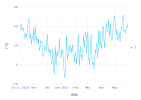

In [59]:
visualize(cf_df, :date, :T;
    kind = :line,
    ylim = (-10, 30),
)

영하로 내려가는 날이 며칠 있는데요, 모형에서 사용하는 상온(`Ta`)을 확인해보겠습니다. 이때 임계온도(`Tc`)를 함께 표시하여 chilling과 forcing이 대략 어느 정도를 차지하는지도 볼 수 있습니다.

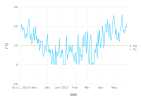

In [60]:
visualize(cf_df, :date, [:Ta, :Tc];
    kind = :line,
    ylim = (-10, 30),
)

그럼 이제 단위 시간당 chilling (`c`)과 forcing (`f`)을 계산해보겠습니다. 위의 그래프에서 임계온도를 기준으로 어떻게 나뉘는지 보이나요?

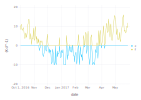

In [61]:
visualize(cf_df, :date, [:c, :f];
    kind = :line,
    ylim = (-20, 20),
)

임계온도(`Tc`)를 직접 바꿔가면서 그래프를 조작해보면 좀 더 확실히 느낌이 옵니다.

In [62]:
manipulate(ChillForceEstimator, :date, [:c, :f];
    config = (cf_config, dc_config, cherry_config(2017)),
    parameters = :ChillForceEstimator => :Tc => 0:0.1:20,
    stop = 8*30u"d",
    kind = :line,
    ylim = (-20, 20),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["ChillForceEstimator"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Tc"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
101, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe00702b5e0, Task (runnable) @0x00007fe00702b5e0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n  

그렇다면 이제 chilling과 forcing이 어떻게 누적되는지 확인해볼 시간입니다. 먼저 chilling(`C`)이 아래쪽으로 누적되기 시작하고 12월 중순경에 저온요구도(`Rc`)를 만족하게 됩니다. 바로 이 시점부터 forcing(`F`)이 반대 방향으로 누적되기 시작하여 계속 증가하다가 4월이 되기 직전 *고온*요구도(`Rf`)를 만족하는 시점이 찾아옵니다. 바로 모형이 예측한 개화일입니다.

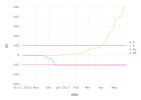

In [63]:
visualize(cf_df, :date, [:C, :F, :Rc, :Rf];
    kind = :line,
    ylim = (-300, 500),
)

역시 움직이는 그래프로 조작해보면 보다 쉽게 이해할 수 있습니다.

In [64]:
manipulate(ChillForceEstimator, :date, [:C, :F, :Rc, :Rf];
    config = (cf_config, dc_config, cherry_config(2017)),
    parameters = :ChillForceEstimator => (;
        Tc = 0:0.1:20,
        Rc = -300:0,
        Rf = 0:500,
    ),
    stop = 8*30u"d",
    kind = :line,
    ylim = (-300, 500),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["ChillForceEstimator"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Tc"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "25%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
101, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/o1I6G/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/o1I6G/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe006bdd120, Task (runnable) @0x00007fe006bdd120), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n  

그런데 만약 겨울이 지나도록 저온요구도를 충족시키지 못한다면 어떻게 될까요? 위의 그래프에서 범위를 조금 바꾼 다음 확인해보세요.

그럼 이제 번거로운 `simulate()` 대신 앞에서 만들어놓은 `estimate()` 함수를 사용하여 보다 간단히 개화일을 예측해보겠습니다.

In [65]:
estimate(ChillForceEstimator, [2017]; config = (cf_config, dc_config))

,year,doy
,Int64,Quantit…
1,2017,89 d


내부적으로는 `simulate()` 함수를 사용하므로 비슷하게 옵션을 넣어줄 수도 있습니다.

In [66]:
estimate(ChillForceEstimator, [2017]; config = (cf_config, dc_config), target = [:C, :F])

,year,doy,C,F
,Int64,Quantit…,Quantit…,Quantit…
1,2017,89 d,-108.2 K,100.7 K


특히 `estimate()` 함수는 여러 연도에 대한 모의를 동시에 수행할 수 있기 때문에 더욱 편리합니다.

In [67]:
estimate(ChillForceEstimator, 2010:2018; config = (cf_config, dc_config), target = [:C, :F])

,year,doy,C,F
,Int64,Quantit…,Quantit…,Quantit…
1,2010,97 d,-106.4 K,109.3 K
2,2011,110 d,-104.5 K,105.2 K
3,2012,82 d,-100.2 K,101.1 K
4,2013,108 d,-100.5 K,101.2 K
5,2014,105 d,-105.8 K,100.5 K
6,2015,110 d,-100.3 K,105.5 K
7,2016,93 d,-108.5 K,111.6 K
8,2017,89 d,-108.2 K,100.7 K
9,2018,114 d,-104.2 K,101.8 K


### 3.5. 관측자료

워싱턴 DC의 국립공원에서 다수를 차지하는 왕벚나무(*Prunus x yedoensis*)의 개화일에 대한 관측은 수십년째 계속되고 있습니다. 모형의 모수를 찾기 위해 이 자료를 활용해보도록 하겠습니다.

In [68]:
cherry_dc_obs = CSV.read("./03-Phenology/cherry_dc_obs.csv", DataFrame) |> unitfy

,year,doy
,Int64,Quantit…
1,1921,79 d
2,1922,97 d
3,1923,99 d
4,1924,104 d
5,1925,86 d
6,1926,101 d
7,1927,79 d
8,1928,99 d
9,1929,90 d


### 3.6. 모수 추정

세개의 모수(`Tc`, `Rc`, `Rf`)를 추정하기 위해 위 관측 기록에서 1991년부터 2010년까지의 자료를 사용하겠습니다. 첫시간에 잠깐 살펴보았던 `calibrate()` 함수를 이용하여 모수를 찾을 수 있습니다.

In [69]:
cf_calib_config = calibrate(ChillForceEstimator, cherry_dc_obs;
    configs = @config(dc_config + cherry_config.(1991:2010)),
    index = :year,
    target = :doy,
    parameters = :ChillForceEstimator => (;
        Tc = (3, 8),
        Rc = (-300, 0),
        Rf = (0, 300),
    ),
    stop = :stop,
    snap = :stop,
    callback,
    optim = (;
        MaxSteps = 1000,
    ),
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.19 secs, 104 evals, 62 steps, improv/step: 0.452 (last = 0.4516), fitness=59.000000000
20.27 secs, 207 evals, 138 steps, improv/step: 0.435 (last = 0.4211), fitness=57.000000000
30.30 secs, 311 evals, 222 steps, improv/step: 0.383 (last = 0.2976), fitness=57.000000000
40.31 secs, 414 evals, 311 steps, improv/step: 0.360 (last = 0.3034), fitness=55.000000000
50.34 secs, 517 evals, 412 steps, improv/step: 0.313 (last = 0.1683), fitness=50.000000000
60.41 secs, 621 evals, 514 steps, improv/step: 0.296 (last = 0.2255), fitness=50.000000000
70.43 secs, 724 evals, 618 steps, improv/step: 0.273 (last = 0.1635), fitness=46.000000000
80.46 secs, 827 evals, 721 steps, improv/step: 0.265 (last = 0.2136), fitness=46.000000000

Config for 1 system:
  ChillForceEstimator
    Tc = 6.17206
    Rc = -158.757
    Rf = 121.861

In [70]:
# cf_calib_config = @config :ChillForceEstimator => (;
#     Tc = 6.17206,
#     Rc = -158.757,
#     Rf = 121.861,
# )

찾아낸 모수를 이용하여 모의를 수행해보겠습니다.

In [71]:
est = estimate(ChillForceEstimator, 1991:2010;
    config = (cf_calib_config, dc_config),
    target = [:C, :F],
)

,year,doy,C,F
,Int64,Quantit…,Quantit…,Quantit…
1,1991,88 d,-163.419 K,130.726 K
2,1992,101 d,-160.187 K,126.522 K
3,1993,106 d,-158.791 K,124.922 K
4,1994,98 d,-161.899 K,126.066 K
5,1995,92 d,-164.287 K,123.01 K
6,1996,92 d,-161.755 K,125.082 K
7,1997,86 d,-163.771 K,126.65 K
8,1998,91 d,-159.212 K,135.798 K
9,1999,97 d,-160.727 K,123.482 K


해당 기간에 관측된 실제 개화일을 확인해보겠습니다.

In [72]:
cherry_dc_obs[1991 .<= cherry_dc_obs[!, :year] .<= 2010, :]

,year,doy
,Int64,Quantit…
1,1991,88 d
2,1992,98 d
3,1993,101 d
4,1994,95 d
5,1995,92 d
6,1996,95 d
7,1997,85 d
8,1998,86 d
9,1999,95 d


그냥 보면 눈에 잘 들어오지 않으니 그래프를 그려서 비교할 수 있도록 `compare()`라는 함수를 하나 만들어보겠습니다.

In [73]:
compare(S, obs, years; config, kw...) = begin
    E = estimate(S, years; config)
    O = obs[obs[!, :year] .∈ Ref(years), :]
    p = plot(O, :year, :doy; name = "Obs", kind = :line, kw...)
    plot!(p, E, :year, :doy; name = "Model", kind = :line)
end

compare (generic function with 1 method)

그럼 다시 1991년에서 2010년까지의 실제 개화일(Obs)과 모형예측(Model)을 비교해보겠습니다.

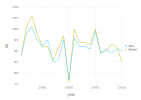

In [74]:
compare(ChillForceEstimator, cherry_dc_obs, 1991:2010;
    config = (cf_calib_config, dc_config),
    ylim = (75, 110),
)

더불어 RMSE와 EF도 계산해볼 수 있습니다.

In [75]:
evaluate(ChillForceEstimator, cherry_dc_obs;
    configs = @config(cf_calib_config + dc_config + cherry_config.(1991:2010)),
    index = :year,
    target = :doy,
    stop = :stop,
    snap = :stop,
    metric = :rmse,
)

2.7838821814150108 d

In [76]:
evaluate(ChillForceEstimator, cherry_dc_obs;
    configs = @config(cf_calib_config + dc_config + cherry_config.(1991:2010)),
    index = :year,
    target = :doy,
    stop = :stop,
    snap = :stop,
    metric = :ef,
)

0.7216235632183907

모수를 찾기 위해 사용했던 기간에 한해서는 3일보다 적은 오차의 준수한 성능을 보여주는 것을 확인하였습니다. 그런데 다른 기간에 적용해도 예측이 잘 될까요?

### 3.7. 평가

이번에는 1937년에서 1990년까지의 개화일을 예측해보도록 하겠습니다. 모수를 추정할 때 사용했던 기간인 1991년에서 2010년까지와는 겹치지 않습니다.

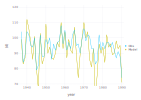

In [77]:
compare(ChillForceEstimator, cherry_dc_obs, 1937:1990; config=(cf_calib_config, dc_config), ylim=(70,120))

RMSE를 계산해보면 평균적으로 대략 1주일 정도의 오차가 발생하는 것을 확인할 수 있습니다.

In [78]:
evaluate(ChillForceEstimator, cherry_dc_obs;
    configs = @config(cf_calib_config + dc_config + cherry_config.(1937:1990)),
    index = :year,
    target = :doy,
    stop = :stop,
    snap = :stop,
    metric = :rmse,
)

7.151793351890709 d

EF는 0에 근접한 값을 보이고 있습니다. 그냥 평균값을 사용하는 것과 큰 차이가 없었다는 의미인데요. 그렇다면 개화 모형은 의미가 없는 것일까요? 왜 이런 결과가 나왔는지, 개선을 위해서는 어떤 접근을 하면 좋을지 생각해볼까요?

In [79]:
evaluate(ChillForceEstimator, cherry_dc_obs;
    configs = @config(cf_calib_config + dc_config + cherry_config.(1937:1990)),
    index = :year,
    target = :doy,
    stop = :stop,
    snap = :stop,
    metric = :ef,
)

-0.018874884721795215

## 3.4. 정리 및 차회예고

이번 시간에는 생물계절 모형의 전형적인 구조에 대하여 살펴보았습니다. 작물모형에서는 온도를 기준으로 생물계절 관련 기작을 표현하는 경우가 많기 때문에 개념적인 측면에서는 이번 시간에 다룬 내용들이 적용될 수 있는 사례가 많을 것으로 생각합니다. 하지만 기작에 따라 광주기(photoperiod)나 기타 환경 요인에 의한 영향을 함께 고려해야 할 수 있다는 점은 유의하셔야 합니다. 한편으로는 마치 chilling forcing 모형의 2단계 구조를 확장하는 것처럼 조건에 따라 과정을 여러 단계로 나누어 순차적 혹은 선별적으로 처리해야할 수도 있는데, 이때에는 [BBCH](https://en.wikipedia.org/wiki/BBCH-scale)와 같이 미리 약속된 척도를 사용하는 것도 고려해볼 수 있습니다.

다음 마지막 시간에는 첫 시간에 잠깐 맛보기를 하였던 마늘 모형을 기준으로 지금까지 배웠던 광합성이나 생물계절 등의 요소들이 실제 어떻게 들어가는지, 다른 주요 부분들은 어떻게 구성되는지 살펴보면서 실제 작물모형의 통합된 구조에 대해 알아보는 시간을 가질 예정입니다. 그외에 시간이 허락한다면 Cropbox를 활용한 다른 사례들도 간략히 소개해드리고, 나머지 시간에는 워크샵 전반에 대한 질의응답 및 토의를 진행하도록 하겠습니다.